In [1]:
#王浩天的笔记本
print('============================xingyun的笔记本=============================')
%pip install d2l
%pip install Ipython
%pip install efficientnet_pytorch   #（可选）
%pip install timm


============================xingyun的笔记本=============================
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#（可选）'


Note: you may need to restart the kernel to use updated packages.


In [5]:
large = torchvision.models.mobilenet_v3_large(pretrained=True)
print(large)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

epoch 200, train loss 0.082, train acc 0.970, valid loss 0.069, valid acc 0.975
1108.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]
Epoch 1: train loss 1.962, train acc 0.351, valid loss 1.884, valid acc 0.393
Epoch 2: train loss 1.241, train acc 0.658, valid loss 1.190, valid acc 0.642
Epoch 3: train loss 0.850, train acc 0.750, valid loss 0.795, valid acc 0.769
Epoch 4: train loss 0.659, train acc 0.796, valid loss 0.550, valid acc 0.845
Epoch 5: train loss 0.584, train acc 0.815, valid loss 0.478, valid acc 0.855
Epoch 6: train loss 0.490, train acc 0.840, valid loss 0.409, valid acc 0.873
Epoch 7: train loss 0.476, train acc 0.840, valid loss 0.342, valid acc 0.902
Epoch 8: train loss 0.422, train acc 0.862, valid loss 0.330, valid acc 0.894
Epoch 9: train loss 0.403, train acc 0.868, valid loss 0.299, valid acc 0.907
Epoch 10: train loss 0.370, train acc 0.878, valid loss 0.267, valid acc 0.920
Epoch 11: train loss 0.372, train acc 0.878, valid loss

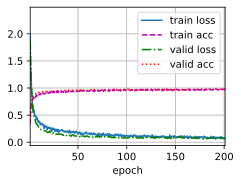

In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
import timm
from torch import nn
from d2l import torch as d2l
import re
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from efficientnet_pytorch import EfficientNet  
from sklearn.model_selection import KFold
from torchvision.models import resnet101, resnet152, resnet18, resnet34, resnet50,mobilenet,mobilenet_v2,mobilenet_v3_large, mobilenet_v3_small, mobilenetv2, mobilenetv3



class FineTuneModel:
    """
    管理预训练模型：
    1. EfficientNet系列模型  
    2. InceptionNet系列模型
    3. ResNet系列模型
    4. MobileNet系列模型

    """
    def __init__(self, devices, num_classes,model_name):
        self.devices = devices
        self.num_classes = num_classes
        self.model_name = model_name

    def get_efficientnet(self):
        """
        微调EfficientNet模型。
        :param model_name: EfficientNet模型的版本，如'efficientnet-b0'到'efficientnet-b7'。
        :return: 微调后的模型。
        """
        # 加载预训练的EfficientNet模型
        finetune_net = EfficientNet.from_pretrained(self.model_name)
        # 替换输出层
        num_ftrs = finetune_net._fc.in_features
        finetune_net._fc = nn.Linear(num_ftrs, self.num_classes)
        # 将模型参数分配到设备上
        finetune_net = finetune_net.to(self.devices[0])
        # 冻结所有层（除了最后的全连接层）
        for name, param in finetune_net.named_parameters():
            if 'fc' not in name:  # 不冻结全连接层
                param.requires_grad = False
        # 确保全连接层的参数可训练
        for param in finetune_net._fc.parameters():
            param.requires_grad = True
        return finetune_net

    def get_mobilenet(self):
        """
        加载预训练的MobileNet模型并进行微调设置。
        'mobilenet',
        'mobilenet_v2',
        'mobilenet_v3_large', 
        'mobilenet_v3_small', 
        'mobilenetv2', 
        'mobilenetv3',
        """
        # 加载预训练的MobileNetV2模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        if self.model_name == "mobilenet_v2":
            num_features = base_model.classifier[-1].in_features
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        else:
                 # 获取最后一个卷积层的输出通道数量
            num_features = base_model.features[-1].out_channels
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices[0])
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'classifier' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False
        return base_model
    
    
    
    def get_resnet(self):
        #加载预训练的resnet模型
        """
        resnet101, 
        resnet152, 
        resnet18, 
        resnet34, 
        resnet50
        """
        # 从torchvision.models模块中动态获取模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        num_features = base_model.fc.in_features
        # 定义一个新的分类头
        classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256,self.num_classes)
        )
        # 替换原有的全连接层（分类头）
        base_model.fc = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices[0])
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'fc' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False

        return base_model



class MyImageClassifier:
    """
    1. 数据处理
    2. 模型训练
    3. 参数调优
    4. 模型保存
    """
    def __init__(self, data_dir, target_dir, batch_size, valid_ratio,train_folder,test_folder):
        self.data_dir = data_dir
        self.target_dir = target_dir
        self.batch_size = batch_size
        self.valid_ratio = valid_ratio
        self.train_folder = train_folder
        self.test_folder = test_folder
        
    def read_csv_labels(self, fname):
        """读取fname来给标签字典返回一个文件名"""
        with open(fname, 'r') as f:
            # 跳过文件头行(列名)
            lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        return dict(((name, label) for name, label in tokens))
    
    def copyfile(self,filename, target_dir):
        """将文件复制到目标目录"""
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(filename, target_dir)
        
    def reorg_train_valid(self,labels):
        """将验证集从原始的训练集中拆分出来"""
        # 训练数据集中样本最少的类别中的样本数
        n = collections.Counter(labels.values()).most_common()[-1][1]
        # 验证集中每个类别的样本数
        n_valid_per_label = max(1, math.floor(n * self.valid_ratio))
        label_count = {}
        for train_file in os.listdir(os.path.join(self.data_dir, self.train_folder)):
            label = labels[train_file.split('.')[0]]
            fname = os.path.join(self.data_dir, self.train_folder, train_file)
            self.copyfile(fname, os.path.join(self.target_dir, 'train_valid_test',
                                         'train_valid', label))
            if label not in label_count or label_count[label] < n_valid_per_label:
                self.copyfile(fname, os.path.join(self.target_dir, 'train_valid_test',
                                             'valid', label))
                label_count[label] = label_count.get(label, 0) + 1
            else:
                self.copyfile(fname, os.path.join(self.target_dir, 'train_valid_test',
                                             'train', label))
        return n_valid_per_label


    def reorg_test(self):
        """在预测期间整理测试集，以方便读取"""
        for test_file in os.listdir(os.path.join(self.data_dir, self.test_folder)):
            self.copyfile(os.path.join(self.data_dir, self.test_folder, test_file),
                     os.path.join(self.target_dir, 'train_valid_test', 'test',
                                  'unknown'))

    def reorg_san_data(self,labels_csv):
        labels = self.read_csv_labels(os.path.join(self.data_dir,labels_csv))
        self.reorg_train_valid(labels)
        self.reorg_test()
        print('# 训练样本 :', len(labels))
        print('# 类别 :', len(set(labels.values())))
        
    """
    以上为数据整理函数
    """
    
    def classes(self):
        class_to_idx = {}
        # 遍历数据集文件夹中的子文件夹（每个子文件夹代表一个类别）
        for idx, class_name in enumerate(sorted(os.listdir(os.path.join(self.target_dir, 'train_valid_test', 'valid')))):
            if class_name.startswith('.'):
                continue
            class_dir = os.path.join(os.path.join(self.target_dir, 'train_valid_test', 'valid'), class_name)  # 类别文件夹路径
            if os.path.isdir(class_dir):
                class_to_idx[idx] = class_name
        print(class_to_idx)
        print("============================")
        return class_to_idx
    
    #统计划分的训练集、验证集数量
    def count_samples(self):
        """统计每个类别训练集和验证集的数量"""
        train_valid_test_dirs = ['train', 'valid']
        data_counts = {'class': []}
        for dir_name in train_valid_test_dirs:
            class_dir = os.path.join(self.target_dir, 'train_valid_test', dir_name)
            if dir_name not in data_counts:
                data_counts[dir_name] = []
            for class_name in os.listdir(class_dir):
                if class_name.startswith('.'):
                    continue
                class_sub_dir = os.path.join(class_dir, class_name)
                if os.path.isdir(class_sub_dir):
                    if class_name not in data_counts['class']:
                        data_counts['class'].append(class_name)
                        for key in train_valid_test_dirs:
                            if key not in data_counts:
                                data_counts[key] = [0] * len(data_counts['class'])
                            else:
                                data_counts[key].append(0)
                    data_counts[dir_name][data_counts['class'].index(class_name)] += len(os.listdir(class_sub_dir))
        df = pd.DataFrame(data_counts)
        return df

    
    def shuju_zq_jz(self,batch_size):
        #数据增强
        transform_train = torchvision.transforms.Compose([
        # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
        # 然后，缩放图像以创建224x224的新图像
        torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                                 ratio=(3.0/4.0, 4.0/3.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        # 随机更改亮度，对比度和饱和度
        torchvision.transforms.ColorJitter(brightness=0.4,
                                           contrast=0.4,
                                           saturation=0.4),
        #转换为张量格式
        torchvision.transforms.ToTensor(),
        # 标准化图像的每个通道
        torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])])

        #测试时，我们只使用确定性的图像预处理操作
        transform_test = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            # 从图像中心裁切224x224大小的图片
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])])
        
        
        #读取整理后的含原始图像文件的数据集
        train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
            os.path.join(self.target_dir, 'train_valid_test', folder),
            transform=transform_train) for folder in ['train', 'train_valid']]

        valid_ds, test_ds = [torchvision.datasets.ImageFolder(
            os.path.join(self.target_dir, 'train_valid_test', folder),
            transform=transform_test) for folder in ['valid', 'test']]


        train_iter, train_valid_iter = [torch.utils.data.DataLoader(
            dataset, batch_size, shuffle=True, drop_last=True)
            for dataset in (train_ds, train_valid_ds)]

        valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                                 drop_last=False)

        test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                                drop_last=False)
        
        return train_iter,valid_iter,test_iter,train_valid_iter
    
    
    """
    以上为数据处理函数
    """
        
        
    #微调预训练模型
    def get_net(self,devices,num_classes,model_name,model_leibie):
        fine_tune_model = FineTuneModel(d2l.try_all_gpus(), num_classes=num_classes,model_name = model_name)  # 使用微调模型
        if model_leibie == 'get_efficientnet':
            base_model = fine_tune_model.get_efficientnet()
        elif model_leibie == 'get_mobilenet':
            base_model = fine_tune_model.get_mobilenet()
        elif model_leibie == 'get_resnet':
            base_model = fine_tune_model.get_resnet()
    
    
        return base_model
        


    
    def evaluate_loss(self,data_iter, net, devices):
        loss = nn.CrossEntropyLoss(reduction='none')  #reduction='none'表示不对损失进行平均或求和，而是返回每个样本的损失值。
        l_sum, n = 0.0, 0
        for features, labels in data_iter:
            features, labels = features.to(devices[0]), labels.to(devices[0])
            outputs = net(features)
            l = loss(outputs, labels)
            l_sum += l.sum()
            n += labels.numel() #累加样本数量到n中，labels.numel()返回标签张量中元素的个数
        return (l_sum / n).to('cpu') #计算所有样本的平均损失值，并将其移动到CPU上返回
    

#     def train(self, net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
#         net = nn.DataParallel(net, device_ids=devices).to(devices[0])
#         trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)
#         scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
#         num_batches, timer = len(train_iter), d2l.Timer()
#         legend = ['train loss', 'train acc']
#         if valid_iter is not None:
#             legend += ['valid loss', 'valid acc']
#         animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
#         loss = nn.CrossEntropyLoss(reduction='none')
#         best_acc = 0  # 初始化最佳准确率
#         best_model_path = ""  # 初始化最佳模型的路径
        
        
#         measures_list = []  # 创建一个列表来存储每10个 epochs 的 measures
#         examples_sec_list = []  # 创建一个列表来存储每10个 epochs 的 examples/sec
#         for epoch in range(num_epochs):
#             metric = d2l.Accumulator(3)
#             for i, (features, labels) in enumerate(train_iter):
#                 timer.start()
#                 features, labels = features.to(devices[0]), labels.to(devices[0])
#                 trainer.zero_grad()
#                 output = net(features)
#                 l = loss(output, labels).sum()
#                 l.backward()
#                 trainer.step()
#                 metric.add(l, labels.shape[0], d2l.accuracy(output, labels))
#                 timer.stop()
#                 if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
#                     animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], metric[2] / metric[1], None, None))
#             measures = f'train loss {metric[0] / metric[1]:.3f},train acc {metric[2] / metric[1]:.3f}'
#             if valid_iter is not None:
#                 valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
#                 measures += f', valid acc {valid_acc:.3f}'
#                 if valid_acc >= best_acc:  # 如果当前模型的验证精度更好
#                     best_acc = valid_acc  # 更新最佳精度
#                     best_model_path = f'model_bests.pth'
#                     torch.save(net, best_model_path)  # 保存模型
#                     torch.save(net.state_dict(), 'model_best_canshu.pth')
#                     print(f"Best model saved to {best_model_path} with accuracy {best_acc:.3f}")

#             measures_list.append(measures)
#             examples_sec = f'epoch {epoch}, {metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}'
#             examples_sec_list.append(examples_sec)
#             print(f'epoch {epoch}, ' + measures + f'\n{metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')
#             scheduler.step()

#         for i, measure in enumerate(measures_list):
#             print(f"Epoch {(i+1)}: {measure}")

#         print(examples_sec_list)  # 打印 examples/sec 列表
#         return measures_list, examples_sec_list
    def train(self, net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
        net = nn.DataParallel(net, device_ids=devices).to(devices[0])
        trainer = torch.optim.SGD((param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
        num_batches, timer = len(train_iter), d2l.Timer()
        legend = ['train loss', 'train acc', 'valid loss', 'valid acc']  # Add valid loss and acc
        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
        loss = nn.CrossEntropyLoss(reduction='none')
        best_acc = 0
        best_model_path = ""
        measures_list = []
        examples_sec_list = []
        for epoch in range(num_epochs):
            metric = d2l.Accumulator(3)
            net.train()  # Switch to training mode
            for i, (features, labels) in enumerate(train_iter):
                timer.start()
                features, labels = features.to(devices[0]), labels.to(devices[0])
                trainer.zero_grad()
                output = net(features)
                l = loss(output, labels).sum()
                l.backward()
                trainer.step()
                metric.add(l, labels.shape[0], d2l.accuracy(output, labels))
                timer.stop()
                if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                    animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], metric[2] / metric[1], None, None))

            measures = f'train loss {metric[0] / metric[1]:.3f}, train acc {metric[2] / metric[1]:.3f}'
            if valid_iter is not None:
                net.eval()  # Switch to evaluation mode
                valid_metric = d2l.Accumulator(3)
                with torch.no_grad():
                    for valid_features, valid_labels in valid_iter:
                        valid_features, valid_labels = valid_features.to(devices[0]), valid_labels.to(devices[0])
                        valid_output = net(valid_features)
                        valid_l = loss(valid_output, valid_labels).sum()
                        valid_metric.add(valid_l, valid_labels.shape[0], d2l.accuracy(valid_output, valid_labels))
                valid_acc = valid_metric[2] / valid_metric[1]
                animator.add(epoch + 1, (None, None, valid_metric[0] / valid_metric[1], valid_acc))
                measures += f', valid loss {valid_metric[0] / valid_metric[1]:.3f}, valid acc {valid_acc:.3f}'
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    best_model_path = f'model_bests.pth'
                    torch.save(net, best_model_path)
                    print(f"Best model saved to {best_model_path} with accuracy {best_acc:.3f}")

            measures_list.append(measures)
            examples_sec = f'epoch {epoch}, {metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}'
            examples_sec_list.append(examples_sec)
            print(f'epoch {epoch}, ' + measures + f'\n{metric[1] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')
            scheduler.step()

        for i, measure in enumerate(measures_list):
            print(f"Epoch {(i+1)}: {measure}")

        print(examples_sec_list)
        return measures_list, examples_sec_list

    
    
    def get_valid_acc(self,measures):
        return float(re.search(r'valid acc (\d+\.\d+)', measures).group(1))

    # 训练参数调优
    def train_parameter_tuning(self, param_grid,num_classes,batch_size,model_name,model_leibie):
        # 使用网格搜索来搜索最佳超参数组合
        best_accuracy = 0
        best_params = None
        # 初始化列表，用于存储包含验证准确率和参数的元组  
        acc_param_list = [] 
        measures_lt = []
  

        for params in product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), params))
            print("Training with params:", param_dict)

            # 创建和训练模型
            net = self.get_net(d2l.try_all_gpus(),num_classes,model_name,model_leibie)
            train_iter,valid_iter = self.shuju_zq_jz(batch_size)[0],self.shuju_zq_jz(batch_size)[1]
            measures_list,examples_sec_list = self.train(net, train_iter, valid_iter, **param_dict,devices = d2l.try_all_gpus())
            # 在验证集上评估模型性能
            # 使用正则表达式提取valid acc对应的数值
            best_measures = max(measures_list, key=self.get_valid_acc)
            valid_acc = float(re.search(r'valid acc (\d+\.\d+)', best_measures).group(1))
            print(best_measures)
            
            # 将验证准确率和参数字典合并为一个元组，并添加到列表中  
            acc_param_list.append((valid_acc, param_dict))  
            measures_lt.append(best_measures)

#             net.load_state_dict(torch.load("model_best.pth"))  # 加载最佳模型
            net = torch.load('model_bests.pth')

            if valid_acc > best_accuracy:
                best_accuracy = valid_acc
                best_params = param_dict
                best_net = net  # 这里的最佳网络是从最佳模型加载的

        for i,measure in enumerate(measures_lt):
            print(f"Trial {i+1}:")
            print(measure)

        print("========================================================")
        print()

        best_acc_index = max(range(len(acc_param_list)), key=lambda i: acc_param_list[i][0])  
        best_accuracy = acc_param_list[best_acc_index][0]  
        best_params = acc_param_list[best_acc_index][1]  

        print("================================================")
        print("Best accuracy:", best_accuracy)  
        print("Best params:", best_params)  
        print()

        for i, (acc, params) in enumerate(acc_param_list):  
            print(f"Trial {i+1}: valid acc {acc}, params {params}")

        return best_net  # 这是从最佳模型加载的网络
        
    """
    以上为模型训练以及参数调优函数
    """
        
        
    #保存训练得到的模型权重文件
    def save_model(self,model_path,model_path_zheng,best_net):
        torch.save(best_net.state_dict(), model_path)  #只保存模型的参数
        torch.save(best_net, model_path_zheng)  #保存整个模型
        print(f"Model saved to {model_path}")


class ViewResult:
    """
    查看训练效果:
    1. 查看每一类在验证集上的准确率
    2. 查看precision，recall和f1-score(即分类报告)
    3. 查看混淆矩阵
    4. 查看AUC-ROC曲线
    """
    def __init__(self, best_net, valid_iter, devices, classes):
        self.net = best_net
        self.valid_iter = valid_iter
        self.devices = devices
        self.classes = classes
        self.num_classes = len(classes)

    def view_result(self):
        print(self.num_classes)
        class_correct = [0.] * self.num_classes
        class_total = [0.] * self.num_classes
        y_test, y_pred = [], []
        X_test = []

        with torch.no_grad():
            for images, labels in self.valid_iter:
                X_test.extend([_ for _ in images])
                outputs = self.net(images.to(self.devices[0]))
                _, predicted = torch.max(outputs, 1)
                predicted = predicted.cpu()
                c = (predicted == labels).squeeze()
                for i, label in enumerate(labels):
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
                y_pred.extend(predicted.numpy())
                y_test.extend(labels.cpu().numpy())

        for i in range(self.num_classes):
            if class_total[i] != 0:
                accuracy = 100 * class_correct[i] / class_total[i]
            else:
                accuracy = 0

            print(f"Accuracy of {self.classes[i]:5s}: {accuracy:2.0f}%")
            
        #分类报告
        try:
            cr = classification_report(y_test, y_pred, target_names=list(self.classes.values()))
            print(cr)
        except Exception as e:
            print("An error occurred while generating the classification report:", str(e))
        
        #混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v != 0 else f"")
        plt.figure(figsize=(25, 20))
        sns.heatmap(cm, annot=labels, fmt='s', xticklabels=self.classes.items(), yticklabels=self.classes.items(), linewidths=0.1)
        plt.show()
        
        

    def evaluate_roc(self, num_classes):
        self.net.eval()
        y_true = []
        y_score = []
        for X, y in self.valid_iter:
            X, y = X.to(self.devices[0]), y.to(self.devices[0])
            y_true.append(y.cpu().numpy())
            y_score.append(self.net(X).detach().cpu().numpy())

        y_true = np.concatenate(y_true)
        y_score = np.concatenate(y_score)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_classes):
            y_true_i = np.where(y_true == i, 1, 0)
            y_score_i = y_score[:, i]

            fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(15, 15))
        colors = list(mcolors.CSS4_COLORS.values())
        colors = colors[:num_classes]
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i}, AUC = {roc_auc[i]:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic for Multi-class Classification')
        plt.legend(loc="lower right")
        plt.show()
        
        
def leibie_class(leibie,num_classes,batch_size,valid_ratio,param_grid,model_path,target_dir,model_name,model_leibie,train_folder,test_folder,model_path_zheng):
    """
    leibie: #填写是几分类的标签文件，如要进行十分类，则填写labels.csv;要进行五分类，则填写labels_5.csv；要进行二分类，填写labels_2.csv.
    num_classes : #填写与leibie对应的类别数字，如要进行十分类，填写数字10，以此类推。
    batch_size : #批量大小，即每次处理的样本数量。
    valid_ratio : #验证集所占比例，如为0.3，则代表验证集占比为30%；即验证集：训练集==3：7。以此类推
    param_grid : #定义要调整的参数范围,通过网格搜索，遍历出最佳模型，获取对应的参数。
    model_path : #最佳模型权重文件保存路径，如'/kaggle/working/model_xcy_shi_1.pth'，可以更改'/model_xcy_shi_1.pth',前面的‘/kaggle/working/’不能改变。
    target_dir : #整理后目标文件存放的目录，如‘/kaggle/working/my_directory_shi’，代表是按十分类整理的文件；‘/kaggle/working/my_directory_wu’则代表是按五分类整理的文件。以此类推。
    model_name : #加载模型的名字。例如：'resnet34'
    model_leibie : #加载模型所属类别函数。例如： 'get_resnet'
    train_folder : #原始训练集存放文件夹
    test_folder : #原始测试集存放文件夹
    model_path_zheng : #完整模型存放路径
    
    """
    data_dir = "/kaggle/input/sanyeqing/"  #存放原始数据的目录
    image_classifier = MyImageClassifier(data_dir, target_dir, batch_size, valid_ratio,train_folder,test_folder) #图像分类训练模型类的实例化
    #调用类中的函数：
    image_classifier.reorg_san_data(leibie) #十分类(labels.csv为十分类，labels_5.csv为五分类......)
    valid_iter=image_classifier.shuju_zq_jz(batch_size)[1]  #数据增强处理函数,
    class_to_idx=image_classifier.classes() #返回分类标签与索引对应函数
    print(class_to_idx)
    best_net = image_classifier.train_parameter_tuning(param_grid,num_classes,batch_size,model_name,model_leibie) #十分类(10为十分类,5则为五分类......)
#     print("===================================================")
#     print("最终的保存模型：")
#     image_classifier.save_model(model_path,model_path_zheng,best_net)
#     print();print()
     #训练结果可视化：
#     result_viewer = ViewResult(best_net, valid_iter, devices=d2l.try_all_gpus(), classes=class_to_idx)
#     result_viewer.view_result()
#     result_viewer.evaluate_roc(num_classes)
    
# 使用示例
if __name__ == '__main__':
        # 定义要调整的参数范围
    param_grid = {
            'num_epochs': [201],
            'lr': [1e-4],
            'wd': [1e-4],
            'lr_period': [2],
            'lr_decay': [1]
    }

    print("这是省份分类：")
    
    leibie_class("labels_hun1.csv",
                 num_classes=11,
                 batch_size=128,
                 valid_ratio=0.2,
                 param_grid=param_grid,
#                  model_path='/kaggle/working/model_wht_wu.pth',
                 model_path=None,
                 target_dir='/kaggle/working/my_directory_shi',
                 model_name='mobilenet_v3_large',
                 model_leibie='get_mobilenet',
                 train_folder = 'train_hun_weizhi_11',
                 test_folder='test_hun_weizhi_11',
                 model_path_zheng=None) #省份分类


{'0': '云南昆明', '1': '云南西双版纳', '2': '广西桂林', '3': '广西玉林', '4': '广西百色', '5': '未知', '6': '浙江台州', '7': '浙江温州', '8': '贵州毕节', '9': '贵州黔西南', '10': '陕西西安'}
总耗时: 134.89秒
测试集图片数: 1327张
每张图片耗时photo_time：0.101651秒
预测准确率test_acc：96.83%
top_n 预测正确的概率是 99.92%
分类报告与各类别准确率
              precision    recall  f1-score   support

        云南昆明       0.93      1.00      0.96       105
      云南西双版纳       0.99      0.97      0.98        88
        广西桂林       0.95      0.95      0.95       113
        广西玉林       0.95      0.93      0.94       107
        广西百色       0.98      1.00      0.99        92
          未知       1.00      0.99      1.00       311
        浙江台州       0.98      0.94      0.96       100
        浙江温州       0.95      0.95      0.95       105
        贵州毕节       0.97      1.00      0.98        94
       贵州黔西南       0.98      0.91      0.94       110
        陕西西安       0.93      0.97      0.95       102

    accuracy                           0.97      1327
   macro avg       0.96      0.96      0.

100%|██████████| 11/11 [00:00<00:00, 1018.51it/s]

              precision    recall  f1-score  support  accuracy
云南昆明           0.929204  1.000000  0.963303    105.0  1.000000
云南西双版纳         0.988372  0.965909  0.977011     88.0  0.965909
广西桂林           0.946903  0.946903  0.946903    113.0  0.946903
广西玉林           0.952381  0.934579  0.943396    107.0  0.934579
广西百色           0.978723  1.000000  0.989247     92.0  1.000000
未知             1.000000  0.993569  0.996774    311.0  0.993569
浙江台州           0.979167  0.940000  0.959184    100.0  0.940000
浙江温州           0.952381  0.952381  0.952381    105.0  0.952381
贵州毕节           0.969072  1.000000  0.984293     94.0  1.000000
贵州黔西南          0.980392  0.909091  0.943396    110.0  0.909091
陕西西安           0.925234  0.970588  0.947368    102.0  0.970588
macro avg      0.963803  0.964820  0.963932   1327.0  0.964820
weighted avg   0.968890  0.968350  0.968291   1327.0  0.968350



/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_34/3860321891.py:336: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.tight_layout(

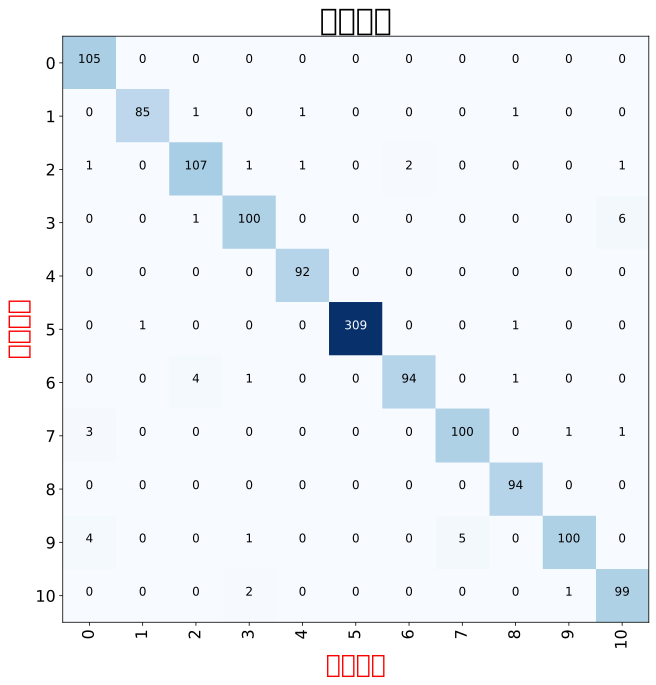

/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from current font.
  plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 26118 (\N{CJK UNIFIED IDEOGRAPH-6606}) missing from current font.
  plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) missing from current font.
  plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 35199 (\N{CJK UNIFIED IDEOGRAPH-897F}) missing from current font.
  plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:407: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) 

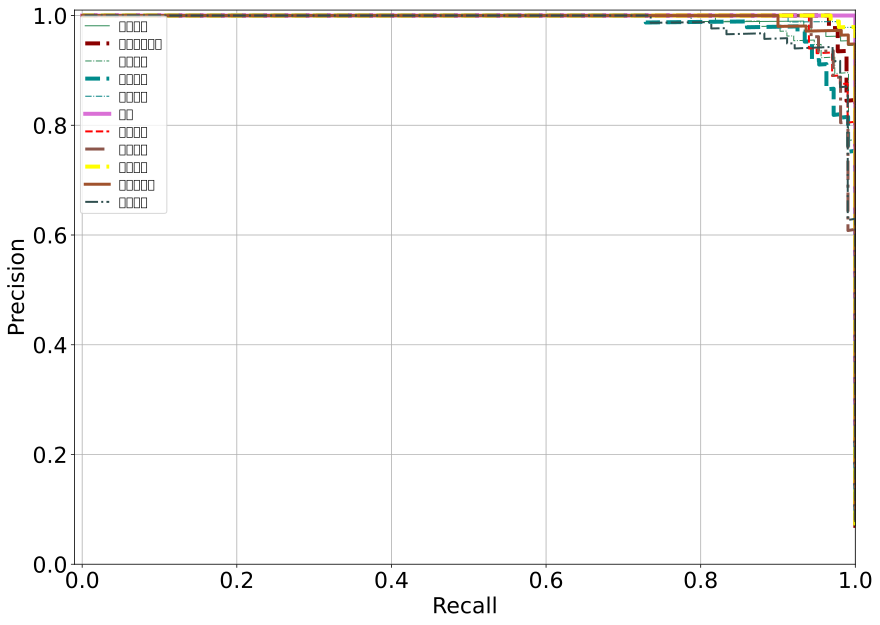

/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from current font.
  plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:441: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-53

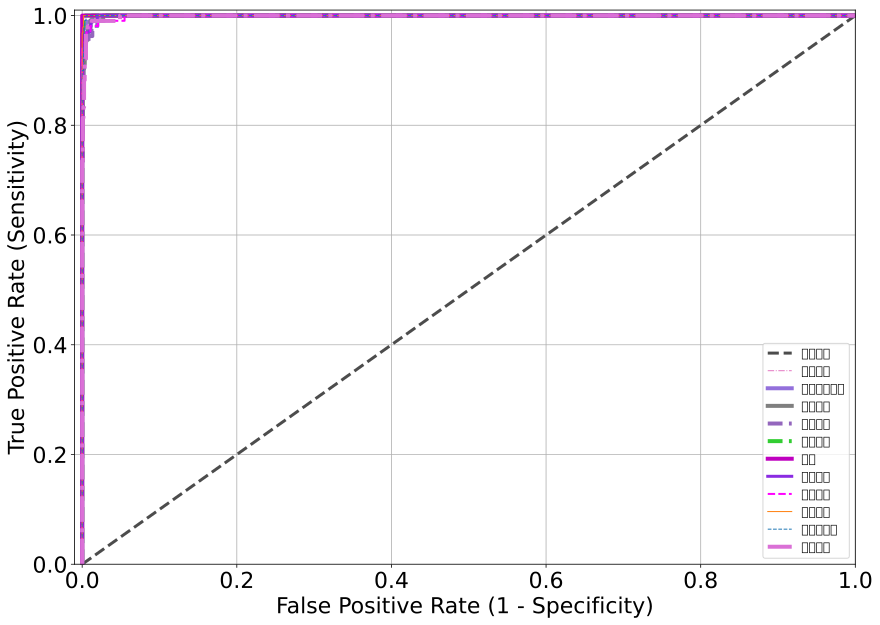

/tmp/ipykernel_34/3860321891.py:480: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:480: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from current font.
  plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:480: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:480: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
/tmp/ipykernel_34/3860321891.py:480: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from current font.
  plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_i

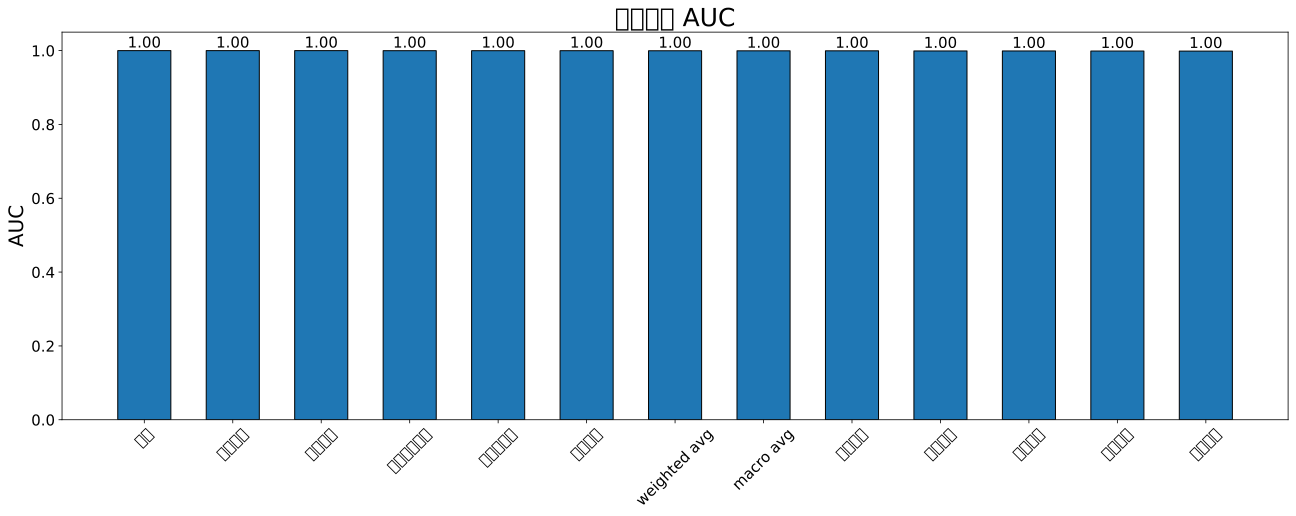

Empty DataFrame
Columns: [img_path, true_class, top_n预测正确, top-1-predicted-class, top-1-probs, top-2-predicted-class, top-2-probs, top-3-predicted-class, top-3-probs, class_云南昆明_prob, class_云南西双版纳_prob, class_广西桂林_prob, class_广西玉林_prob, class_广西百色_prob, class_未知_prob, class_浙江台州_prob, class_浙江温州_prob, class_贵州毕节_prob, class_贵州黔西南_prob, class_陕西西安_prob]
Index: []


In [8]:
# -*- coding: utf-8 -*-
#  所有模型的测试集预测
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
import timm
from torch import nn
from d2l import torch as d2l
import re
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from efficientnet_pytorch import EfficientNet  
from sklearn.model_selection import KFold
from torchvision.models import resnet101, resnet152, resnet18, resnet34, resnet50,mobilenet,mobilenet_v2,mobilenet_v3_large, mobilenet_v3_small, mobilenetv2, mobilenetv3
import cv2
from sklearn.metrics import precision_recall_curve,average_precision_score,classification_report,confusion_matrix,roc_curve,auc
#概率分布预测
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import itertools
from matplotlib import colors as mcolors
import random


class FineTuneModel:
    """
    管理预训练模型：
    1. EfficientNet系列模型  
    2. InceptionNet系列模型
    3. ResNet系列模型
    4. MobileNet系列模型

    """
    def __init__(self, devices, num_classes,model_name):
        self.devices = devices
        self.num_classes = num_classes
        self.model_name = model_name

    def get_efficientnet(self):
        """
        微调EfficientNet模型。
        :param model_name: EfficientNet模型的版本，如'efficientnet-b0'到'efficientnet-b7'。
        :return: 微调后的模型。
        """
        # 加载预训练的EfficientNet模型
        finetune_net = EfficientNet.from_pretrained(self.model_name)
        # 替换输出层
        num_ftrs = finetune_net._fc.in_features
        finetune_net._fc = nn.Linear(num_ftrs, self.num_classes)
        # 将模型参数分配到设备上
        finetune_net = finetune_net.to(self.devices)
        # 冻结所有层（除了最后的全连接层）
        for name, param in finetune_net.named_parameters():
            if 'fc' not in name:  # 不冻结全连接层
                param.requires_grad = False
        # 确保全连接层的参数可训练
        for param in finetune_net._fc.parameters():
            param.requires_grad = True
        return finetune_net

    def get_mobilenet(self):
        """
        加载预训练的MobileNet模型并进行微调设置。
        'mobilenet',
        'mobilenet_v2',
        'mobilenet_v3_large', 
        'mobilenet_v3_small', 
        'mobilenetv2', 
        'mobilenetv3',
        """
        # 加载预训练的MobileNetV2模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        if self.model_name == "mobilenet_v2":
            num_features = base_model.classifier[-1].in_features
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        else:
                 # 获取最后一个卷积层的输出通道数量
            num_features = base_model.features[-1].out_channels
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'classifier' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False
        return base_model
    
    
    
    def get_resnet(self):
        #加载预训练的resnet模型
        """
        resnet101, 
        resnet152, 
        resnet18, 
        resnet34, 
        resnet50
        """
        # 从torchvision.models模块中动态获取模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        num_features = base_model.fc.in_features
        # 定义一个新的分类头
        classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256,self.num_classes)
        )
        # 替换原有的全连接层（分类头）
        base_model.fc = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'fc' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False

        return base_model



 #微调预训练模型
def get_net(devices,num_classes,model_name,model_leibie):
        fine_tune_model = FineTuneModel(devices=devices, num_classes=num_classes,model_name = model_name)  # 使用微调模型
        if model_leibie == 'get_efficientnet':
            base_model = fine_tune_model.get_efficientnet()
        elif model_leibie == 'get_mobilenet':
            base_model = fine_tune_model.get_mobilenet()
        elif model_leibie == 'get_resnet':
            base_model = fine_tune_model.get_resnet()
        return base_model


def predict_(img,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    """
    img: #测试图片路径
    num_classes : #类别数量：11、6、3（因为加了一个未知类别）
    model_name ： #模型名称
    model_weight_pth : #待读取的模型权重的保存路径
    classes： #索引与标签的字典
    model_leibie: #模型类别
    model_path_zheng: #整体模型路径
    is_zheng: #是否整体模型
    """
    #定义了数据转换的操作。通过transforms.ToTensor()将图像转换为张量，transforms.Normalize()对图像进行归一化处理
    data_transform = transforms.Compose([
         transforms.Resize(256),
         # 从图像中心裁切224x224大小的图片
         transforms.CenterCrop(224),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
    ])
    # 有 GPU就用 GPU，没有就用 CPU
    devices = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if img.mode == 'RGBA':  #如果图像是RGBA模式，就将其转换为RGB模式
        img = img.convert('RGB')
    img = data_transform(img) #将输入图像应用数据转换操作
    img = torch.unsqueeze(img, dim=0) #在第0维度上添加一个维度，用于适配网络输入
    img = img.to(devices)   # 将张量移动到GPU上  
    if is_zheng:
        model = torch.load(model_path_zheng)  #直接加载整个模型
    else:
        model = get_net(devices,num_classes,model_name,model_leibie)   #实例化的image_classifier
        model.load_state_dict(torch.load(model_weight_pth)) #指定了模型权重文件路径，并加载权重到模型中
    model.eval() #将模型设置为评估模式，即关闭Dropout和Batch Normalization的随机性
    #将输入图像输入模型中进行推理
    with torch.no_grad():
        output = torch.squeeze(model(img))
        predict = torch.softmax(output, dim=0)
    # 获取每个类别的预测概率
    class_probs = {str(i): round(prob.item(), 5) for i, prob in enumerate(predict)}
    predict_cla = torch.argmax(predict).cpu().numpy()
    max_prob = round(predict[predict_cla].item(), 5)
    predicted_class = classes[str(predict_cla)]
    return predicted_class, max_prob, class_probs



#测试集预测结果、各类别准确率评估指标
def predict_acc_all(labels_path,image_dir,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    #计算在测试集上的准确率
        labels_df = pd.read_csv(labels_path)  #假设labels.csv的格式是：ID,labels
        true_labels = {row['ID']: row['labels'] for _, row in labels_df.iterrows()}  # 创建一个字典来存储真实标签
        img_path_lt = [] #图片路径
        predicted_class_topn_lt = [] #top_n预测类别
        top_n = []  # 初始化 top_n 列表
        true_class_lt = [] #真实类别
        class_probs_list = [] #每个类型的置信度
        correct_count = 0  # 初始化计数器
        total_count = 0
        photo_count = 0 #初始化图片计数器
        import time
        start_time = time.time()  # 开始计时
        # 遍历未知图片目录
    #     image_dir = r"/kaggle/working/my_directory_shi/train_valid_test/test/unknown/"
        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):  # 根据你的图片文件类型调整
                photo_count += 1 #图片个数统计
                base_name = filename.split('.')[0]   # 移除文件名的后缀以匹配labels.csv中的ID
                img_path = os.path.join(image_dir, filename)
                img_path_lt.append(img_path)  #存储图片的路径
                predicted_class, max_prob,class_probs = predict_(Image.open(img_path),num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng) # 预测
                class_probs_list.append(class_probs)
                # 对 class_probs 字典进行排序，返回一个列表，列表的每个元素是一个元组，元组的第一个元素是键，第二个元素是值
                sorted_class_probs = sorted(class_probs.items(), key=lambda x: x[1], reverse=True)
                # 取前三个元素
                top3_class_probs = sorted_class_probs[:3]
#                 print(top3_class_probs)
                # 将 top3_class_probs 添加到 predicted_class_topn_lt 列表中
                predicted_class_topn_lt.append(top3_class_probs)
                
                true_class = true_labels.get(int(base_name), None)  # 获取真实类别，这里使用去除后缀的base_name来查找
                true_class_lt.append(true_class)
#                 检查 top3_class_probs 是否包含真实类别
                if true_class in [classes[str(item[0])] for item in top3_class_probs]:
                    top_n.append(1)
                else:
                    top_n.append(0)
#                 print(top_n)
#                 print(f'真实：{true_class}',f"预测：{predicted_class}",f"最大概率：{max_prob}",f"所有概率:{class_probs}")
                if true_class is None:
                    print(f"警告：找不到ID为{base_name}在labels.csv中的标签，跳过此文件。")
                    continue
                if str(predicted_class) == true_class:   # 更新计数器
                    correct_count += 1
                total_count += 1

        end_time = time.time()  # 结束计时
        total_time = end_time - start_time  # 总处理时间
        print(f"总耗时: {total_time:.2f}秒")
        print(f"测试集图片数: {photo_count}张")
        print(f"每张图片耗时photo_time：{(total_time/photo_count):2f}秒")
        
        # 创建一个字典，其中键是列名，值是数据
        data = {
            'img_path': img_path_lt,
            'true_class': true_class_lt,
            'top_n预测正确': top_n
        }
        
        # 使用循环来添加 top-n 预测类别和置信度的列
        for i in range(3):
            data[f'top-{i+1}-predicted-class'] = [classes[str(item[i][0])] for item in predicted_class_topn_lt]
            data[f'top-{i+1}-probs'] = [item[i][1] for item in predicted_class_topn_lt]

        # 将每个类别的置信度添加到数据字典中
        for i in range(num_classes):
            i_c = classes[str(i)]
            data[f'class_{i_c}_prob'] = [class_probs[str(i)] for class_probs in class_probs_list]
        # 创建 DataFrame
        df = pd.DataFrame(data)
        # 保存为 csv 文件
        df.to_csv('测试集预测结果.csv', index=False)
        # print(df)
        # 计算准确率
        accuracy = correct_count / total_count if total_count > 0 else 0
        print("==============================================")
        print(f"预测准确率test_acc：{accuracy * 100:.2f}%")
        # 计算 top_n 预测正确的概率
        top_n_accuracy = (sum(df['top_n预测正确']) / len(df['top_n预测正确'])) * 100
        print(f"top_n 预测正确的概率是 {top_n_accuracy:.2f}%")
        print("=======================================")
        print("分类报告与各类别准确率")
        print(classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values()))
        report = classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values(), output_dict=True)
        del report['accuracy']
        df_report = pd.DataFrame(report).transpose()
        # print(df_report)
        #各类别准确率
        accuracy_list = []
        for sanye in tqdm(classes.values()):
            df_temp = df[df['true_class']==sanye]
            accuracy = sum(df_temp['true_class'] == df_temp['top-1-predicted-class']) / len(df_temp)
            accuracy_list.append(accuracy)
        # 计算 宏平均准确率 和 加权平均准确率
        acc_macro = np.mean(accuracy_list)
        acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))
        accuracy_list.append(acc_macro)
        accuracy_list.append(acc_weighted)
        df_report['accuracy'] = accuracy_list
        print(df_report)
        df_report.to_csv('各类别准确率评估指标.csv', index_label='类别')


#混淆矩阵
def cnf_matrix_plotter(classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    df = pd.read_csv('测试集预测结果.csv')
    cm = confusion_matrix(df['true_class'], df['top-1-predicted-class'])
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
    # 查看所有配色方案
    # dir(plt.cm)
    return cm
# df = pd.read_csv('测试集预测结果.csv', encoding='utf-8')
# cnf_matrix_plotter(df, classes, cmap='Blues')



#筛选出测试集中，真实为A类，但被误判为B类的图像
def get_wrong_predict(true_A,pred_B,is_plt=True):
    df = pd.read_csv('测试集预测结果.csv')
    wrong_df = df[(df['true_class']==true_A)&(df['top-1-predicted-class']==pred_B)]
    #可视化上表中所有被误判的图像
    if is_plt:
        for idx, row in wrong_df.iterrows():
            img_path = row['img_path']
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                print(f"无法读取图像：{img_path}")
            else:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                title_str = img_path + '\nTrue:' + row['true_class'] + ' Pred:' + row['top-1-predicted-class']
                plt.title(title_str)
                plt.show()
    else:
        return wrong_df
# df = pd.read_csv('测试集预测结果.csv')
# wrong_df = get_wrong_predict(df,'YNKM','SXXA',is_plt=True)


#PR曲线
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
    markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    linestyle = ['--', '-.', '-']
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

#PR曲线
def plot_PR_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    # plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv("测试集预测结果.csv")
    ap_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        AP = average_precision_score(y_test, y_score, average='weighted')
        plt.plot(recall, precision, **get_line_arg(), label=each_class)
        plt.legend()
        ap_list.append(AP)
    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AP值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(ap_list)
    weighted_avg_auc = sum(ap_list * df_report.iloc[:-2]['support'] / len(df))
    ap_list.append(macro_avg_auc)
    ap_list.append(weighted_avg_auc)
    df_report['AP'] = ap_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#ROC曲线
def plot_roc_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv('测试集预测结果.csv')
    auc_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        fpr, tpr, threshold = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, **get_line_arg(), label=each_class)
        plt.legend()
        auc_list.append(auc(fpr, tpr))

    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AUC值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(auc_list)
    weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))
    auc_list.append(macro_avg_auc)
    auc_list.append(weighted_avg_auc)
    df_report['AUC'] = auc_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#绘制各类别评估指标柱状图
def plot_bar_chart(feature):
    """
    绘制各类别评估指标柱状图
    :param df: DataFrame
    :param feature: str
    # feature = 'precision'
    # feature = 'recall'
    # feature = 'f1-score'
    # feature = 'accuracy'
    # feature = 'AP'
    # feature = 'AUC'
    :return:
    """
    df = pd.read_csv('各类别准确率评估指标.csv')
    df_plot = df.sort_values(by=feature, ascending=False)
    plt.figure(figsize=(22, 7))
    x = df_plot['类别']
    y = df_plot[feature]
    ax = plt.bar(x, y, width=0.6, facecolor='#1f77b4', edgecolor='k')
    plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=15)
    # plt.xlabel('类别', fontsize=20)
    plt.ylabel(feature, fontsize=20)
    plt.title('评估指标 {}'.format(feature), fontsize=25)
    plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
    plt.show()
# plot_bar_chart('AUC')







if __name__ == '__main__':
    # # 根据 labels.csv 载入类别和对应 ID
    # idx_to_labels = pd.read_csv("D:\SanYeQing_Project\wht-sanyeqing\idx_to_labels.csv",encoding='utf-8')
    # # 创建一个字典来存储真实标签
    # idx_to_labels = {str(index): row['labels'] for index, row in idx_to_labels.iterrows()}  
    random.seed(124)
    
    #根据json文件获取类别
#     import json
#     class_json_path = '/kaggle/input/sanyeqing/class_5.json'
#     json_file = open(class_json_path, 'rb')
#     idx_to_labels = json.load(json_file)
   
    #直接将json文件中类别、标签字典复制过来
#     idx_to_labels = {
#    "0":"云南省",
#    "1":"广西省",
#    "2":"未知",
#    "3":"浙江省",
#    "4":"贵州省",
#    "5":"陕西省"
# }
    idx_to_labels = {
       "0": "云南昆明",
       "1": "云南西双版纳",
       "2": "广西桂林",
       "3": "广西玉林",
       "4": "广西百色",
       "5": "未知",
       "6": "浙江台州",
       "7": "浙江温州",
       "8": "贵州毕节",
       "9": "贵州黔西南",
       "10": "陕西西安"
    }
    print(idx_to_labels)
    #测试集预测结果、各类别准确率评估指标
    predict_acc_all(labels_path="/kaggle/input/sanyeqing/labels_hun1.csv",
                        image_dir="/kaggle/working/my_directory_shi/train_valid_test/test/unknown/",
                        num_classes=11,
                        model_name=None,
                        model_leibie=None,
                        model_weight_pth=None,
                        classes=idx_to_labels,
                        model_path_zheng="/kaggle/working/model_bests.pth",
                        is_zheng=True)
    #混淆矩阵
    cnf_matrix_plotter(classes=idx_to_labels, cmap='Blues')
    #PR曲线
    plot_PR_curve()
    #ROC曲线
    plot_roc_curve()
    #绘制各类别评估指标柱状图
    plot_bar_chart('AUC')
    #筛选出测试集中，真实为A类，但被误判为B类的图像
    get_wrong_predict(true_A="广西省",pred_B="陕西省",is_plt=True)
    print(get_wrong_predict(true_A="广西省",pred_B="陕西省",is_plt=False))

    

    
    #要加载中文字体
    
#     #单张图片的预测概率 (可选看)
#     from PIL import ImageDraw
#     def show_image(img, title=None):
#         """展示图像"""
#         plt.imshow(img)
#         if title:
#             plt.title(title)
#         #  plt.axis('off')  # 不显示坐标轴
#         plt.show()
#     # 在predict_函数调用之后，添加如下代码来显示图像 
#     img = Image.open(r"/kaggle/working/my_directory_wu/train_valid_test/test/unknown/1582.png")
#     predicted_class ,max_prob,sorted_class_probs= predict_(img, num_classes=6,
#                         model_name=None,
#                         model_weight_pth=None,
#                         classes=idx_to_labels,
#                         model_leibie = None,
#                         model_path_zheng="/kaggle/working/model_wht_wu_zheng.pth",
#                         is_zheng=True
#                                             )
#     # 创建一个 ImageDraw 对象
#     draw = ImageDraw.Draw(img)
#     # 定义起始位置
#     start_x = 10
#     start_y = 10
#     # 定义行间距
#     line_spacing = 15
#     # 将字典转换为列表
#     sorted_class_probs_list = list(sorted_class_probs.items())

#     # 遍历字典，将键和值添加到图像上
#     for key, value in sorted_class_probs_list[:5]:
#         key = idx_to_labels[str(key)]
#         text = f"{key}:       {value}"
#         draw.text((start_x, start_y), text, fill=(255, 0, 0, 1))
#         start_y += line_spacing  # 更新y坐标，以便下一行文本在新的一行
#     # 显示图像
#     show_image(img)  
#     print(f"最可能的类别：{predicted_class}")
#     print(f"最大分类概率：{max_prob}")
#     print(sorted_class_probs)